# Deciding parameter values for profile calculations

Updated Aug 12 by George Lu

Many of the notebooks in the folder `chirp_processing` explores these decisions, and the methods and results are condensed and formalized into this individual notebook. This notebook goes through each seasonal dataset of chirps, and settles on attenuator setting and bandwidth used to calculate the profiles. First, this notebook will illustrate the difference between attenuator choices with an example burst of chirps. Next, it will illustrate the impact of different settings on a clipped burst of chirps v.s. a burst without clipping. As we will see, some of the settings have small effects, so some decisions are on a qualitative basis. Afterwards, we will step through each seasonal dataset and describe the final parameter decisions made.

## Importing libraries and helper scripts
The below section imports the code used in the calculations and figure generation. Most of the code will be contained within `helpers.py` or this section, for the sake of keeping the remaining sections clean

In [18]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43363")
client

<Client: 'tcp://127.0.0.1:43363' processes=4 threads=16, memory=125.80 GiB>

In [3]:
# Load libraries
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    12:56:42 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    12:56:42 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    12:56:42 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


## Different attenuator settings
This section first shows how clipping appears across attenuation settings. It also shows how different attenuation settings impact the amplitude distribution of chirps. From these distributions we make a decision regarding which setting to use in our processing, in addition to a threshold value for chirp amplitude to identify clipping. This example takes a clipped chirp along with a relatively clean chirp and shows the differences in chirp structure, amplitude distribution, and resulting profiles.

Text(0, 0.5, 'Profile Amplitude [dB]')

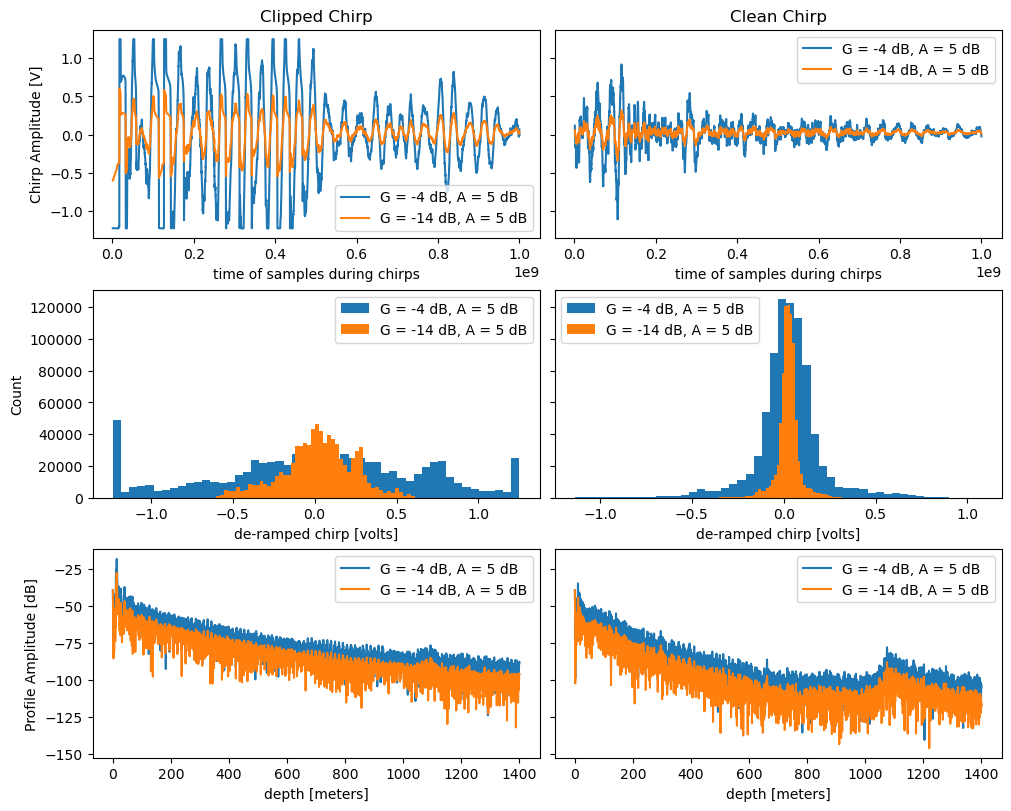

In [4]:
# Attenuator setting plot - clipping

ds_101 = reload("A101")
ds_bad = ds_101.isel(time=7060).isel(chirp_time=range(50,len(ds_101.chirp_time)-1))
ds_good = ds_101.isel(time=118).isel(chirp_time=range(50,len(ds_101.chirp_time)-1))
atten_count = 2
fig, axs = plt.subplots(ncols=2, nrows = 3, figsize = (10,8),sharey='row',layout='constrained')

for i in range(atten_count):
    # plot chirps at top
    for j, ds in zip(range(2),[ds_bad,ds_good]):
        ds.chirp.isel(attenuator_setting_pair=i).mean(dim='chirp_num').plot(ax=axs[0][j],
                                    label = f'G = {int(ds.AFGain[i].values)} dB, A = {int(ds.attenuator[i].values)} dB')
        ds.chirp.isel(attenuator_setting_pair=i).plot.hist(ax=axs[1][j],bins=50,
                                    label = f'G = {int(ds.AFGain[i].values)} dB, A = {int(ds.attenuator[i].values)} dB')

        xa.dB(ds.isel(attenuator_setting_pair = i).profile_stacked).plot(ax=axs[2][j],
                                    label = f'G = {int(ds.AFGain[i].values)} dB, A = {int(ds.attenuator[i].values)} dB')
        axs[0][j].legend()
        axs[1][j].legend()
        axs[2][j].legend()

        axs[1][j].set_title('')
        axs[2][j].set_title('')

axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')
axs[2][1].set_ylabel('')
axs[0][0].set_title('Clipped Chirp')
axs[0][1].set_title('Clean Chirp')

axs[0][0].set_ylabel('Chirp Amplitude [V]')
axs[1][0].set_ylabel('Count')
axs[2][0].set_ylabel('Profile Amplitude [dB]')


## Settings to remove clipping
This section looks at ways we can remove clipping. There are three ways to do so. We can restrict the bandwidth sampled within each chirp to include only non-clipped sections. We can drop chirps with clipping from the 20-chirp bursts that we stack to obtain the profiles. Or, we can drop entire bursts and leave a gap in the data. We end up doing a combination of all 3, with an aim to compromise between preserving spatial resolution of our results (which drops with a reduced bandwidth) and preserving temporal resolution of our measurements (which gets reduced when we drop entire bursts).

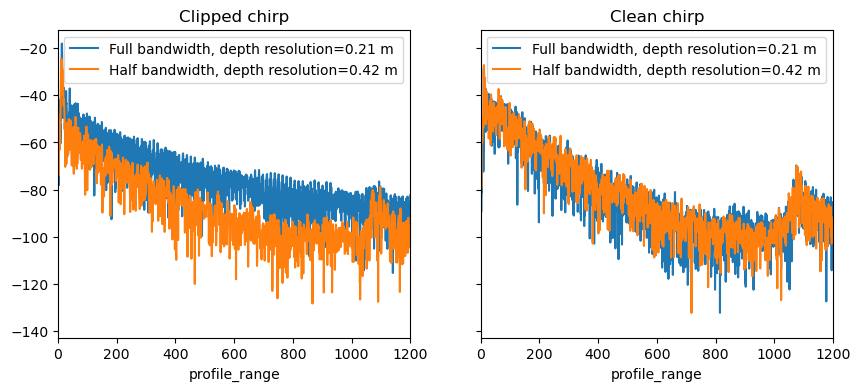

In [5]:
# Impact of reducing bandwidth
ds_bad = ds_101.isel(time=[7060])
ds_good = ds_101.isel(time=[30])

profile_bad_clean = custom_profile(ds_bad.chirp.isel(attenuator_setting_pair = 0),1.2,20,20000)
profile_good_clean = custom_profile(ds_good.chirp.isel(attenuator_setting_pair = 0),1.2,20,20000)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4),sharex=True,sharey=True)
xa.dB(ds_bad.isel(attenuator_setting_pair = 0).profile_stacked).plot(ax=axs[0],
                                                                     label = f'Full bandwidth, depth resolution={float(ds_bad.profile_range.diff(dim='profile_range').mean().values):.2f} m')
xa.dB(profile_bad_clean).plot(ax=axs[0],
                              label = f'Half bandwidth, depth resolution={float(profile_bad_clean.profile_range.diff(dim='profile_range').mean().values):.2f} m')
axs[0].set_xlim([0,1200])
axs[0].set_title('Clipped chirp')
axs[0].legend()

xa.dB(ds_good.isel(attenuator_setting_pair = 0).profile_stacked).plot(ax=axs[1],
                                                                      label = f'Full bandwidth, depth resolution={float(ds_good.profile_range.diff(dim='profile_range').mean().values):.2f} m')
xa.dB(profile_good_clean).plot(ax=axs[1],
                              label = f'Half bandwidth, depth resolution={float(profile_good_clean.profile_range.diff(dim='profile_range').mean().values):.2f} m')
axs[1].set_xlim([0,1200])
axs[1].set_title('Clean chirp')
axs[1].legend()
                                               

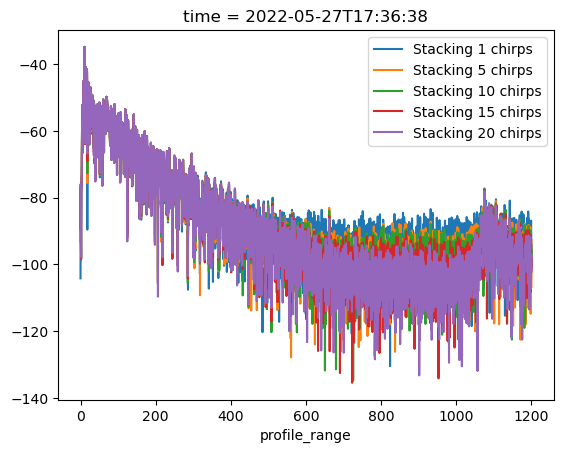

In [6]:
# impact of removing chirps from burst

ds_good = ds_101.isel(time=[118],attenuator_setting_pair=0).compute()#.isel(chirp_time=range(50,len(ds_101.chirp_time)-1))
#xa.dB(ds_good.profile_stacked).plot()
for i in [19,15,10,5,0]:
    profile_good_clean = custom_profile(ds_good.chirp.isel(chirp_num=range(i,20)),1.2,0,0)
    xa.dB(profile_good_clean).plot(label = f'Stacking {20-i} chirps')
plt.legend()

## Individual Station/Season Choices
This section has 2 plots for each station/season. First, a histogram of chirp amplitudes across all attenuator settings. This is to decide on which attenuator setting to use. Next, a plot of all instances of clipping at a specific sample time within each chirp. This is to decide on what bandwidth to use. As shown in the previous section, the amount of each chirps in a burst impacts the noise floor of the profile. From all the histograms, we decide on a generous clipping threshold of 1.2 V. We assign a minimal number of chirps in each burst to be 5, to preserve a lower noise floor. Additionally, there is a sampling artifact at the end of each chirp, so we omit the last two points of each chirp in our calculation. 

In [15]:
def generate_info_plots(ds):
    atten_count = len(ds.attenuator_setting_pair)
    fig, axs = plt.subplots(ncols=atten_count,figsize=(5*atten_count,3),layout='constrained')
    
    for i in range(atten_count):
        ds.chirp.isel(attenuator_setting_pair=i).mean(dim='chirp_num').plot.hist(ax=axs[i],bins=100)
        axs[i].set_title(f'Gain = {int(ds.AFGain[i].values)} dB, Attenuation = {int(ds.attenuator[i].values)} dB')
        axs[i].set_xlabel('chirp voltage [V]')
    axs[0].set_ylabel('count')
    fig.suptitle('Chirp voltage histograms across settings')
    
    fig1,ax1 =  plt.subplots(figsize=(5*atten_count,3))

    bad_chirp_condition = abs(ds.isel(attenuator_setting_pair=0).chirp) > 1.2
    
    ds.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition).count(dim=['chirp_num','time']).plot(ax=ax1,linestyle='None',marker='.')
    ax1.set_ylabel('count')
    ax1.set_title(f'Total instances of clipping in chirp section using: Gain = {int(ds.AFGain[0].values)} dB, Attenuation = {int(ds.attenuator[0].values)} dB')
    ax1.set_xlabel('time of chirp sample [s]')

### A11 Summer 2022

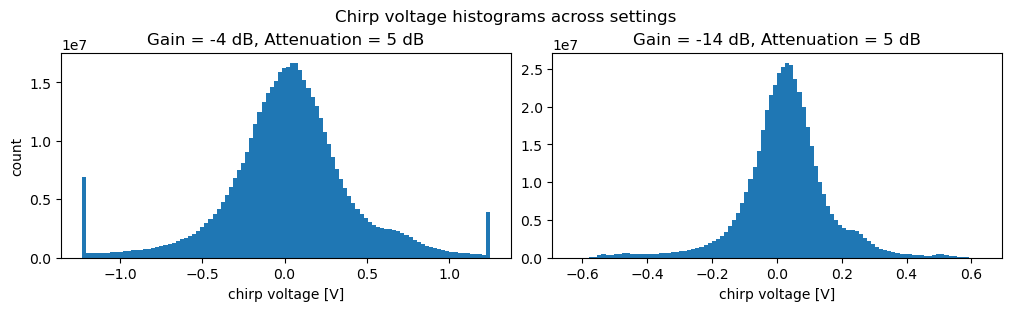

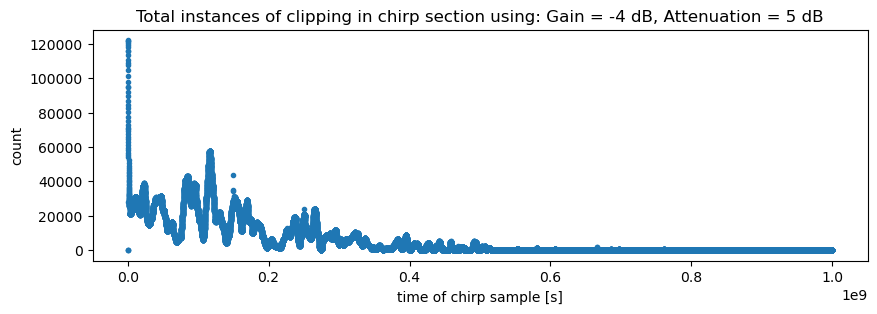

In [16]:
ds_101 = reload("A101")
ds_101 = ds_101.isel(time=range(20,len(ds_101.time))) # trim first few bursts, which were tests
generate_info_plots(ds_101)

### A11 Winter

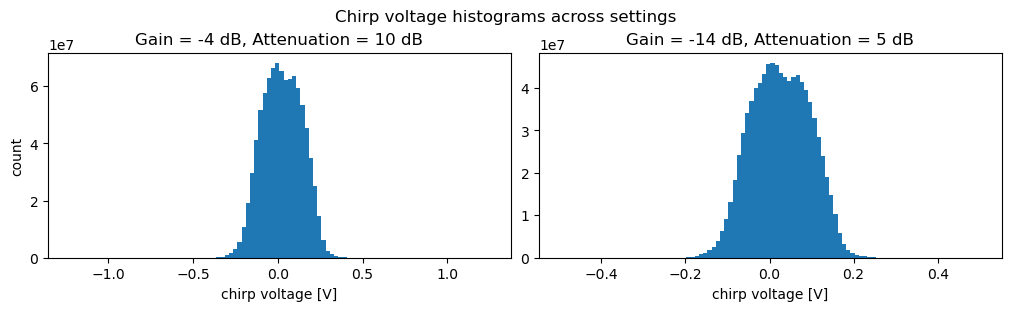

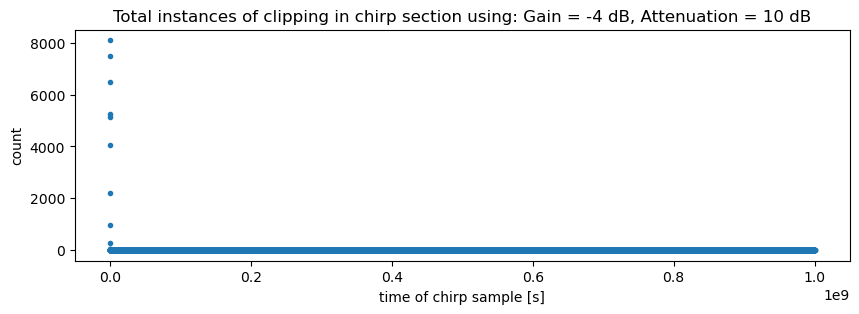

In [19]:
ds_101 = reload_winter("A101")
generate_info_plots(ds_101)

### A13 Summer 2022

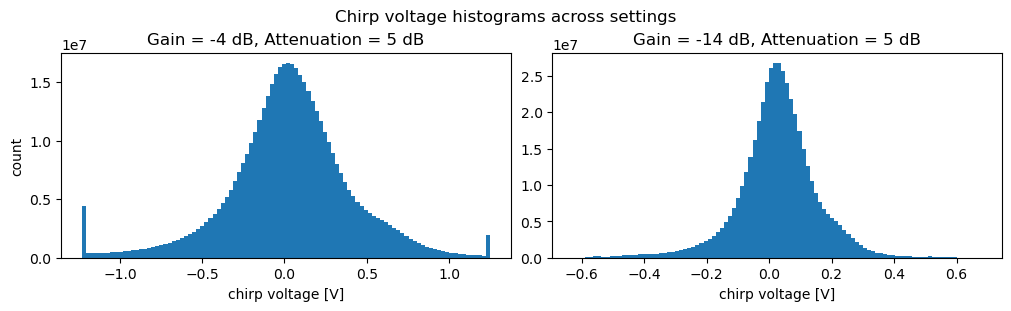

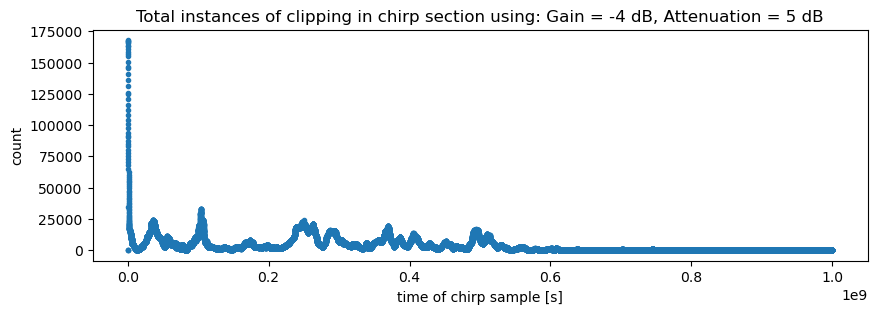

In [20]:
ds_103 = reload("A103_fixed")
ds_103 = ds_103.isel(time=range(60,len(ds_103.time))) # trim first few bursts, which were tests
generate_info_plots(ds_103)

### A13 Winter

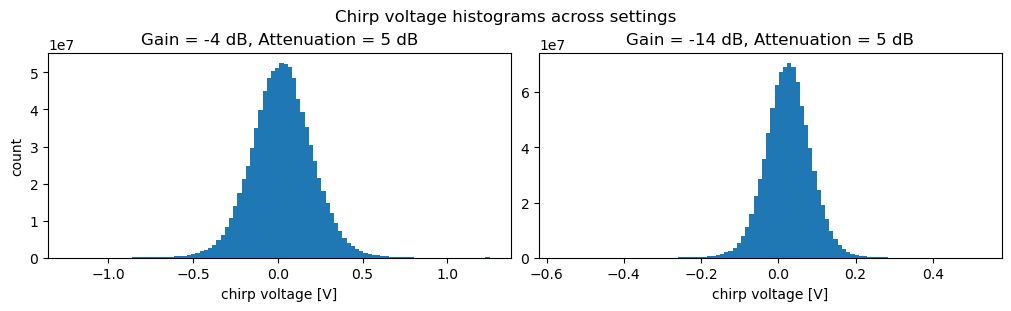

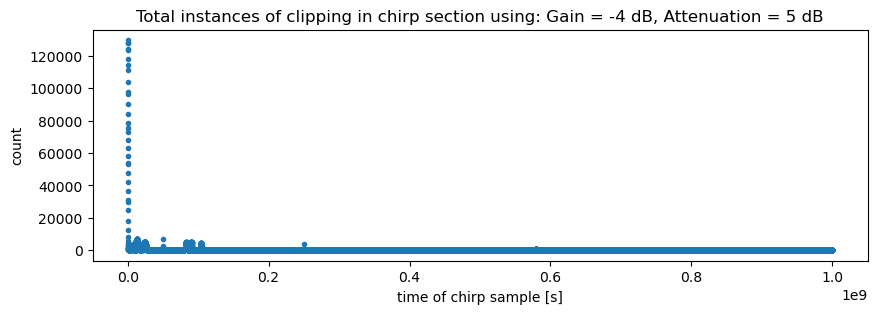

In [21]:
ds_103 = reload_winter("A103")
generate_info_plots(ds_103)

### A13 Summer 2023

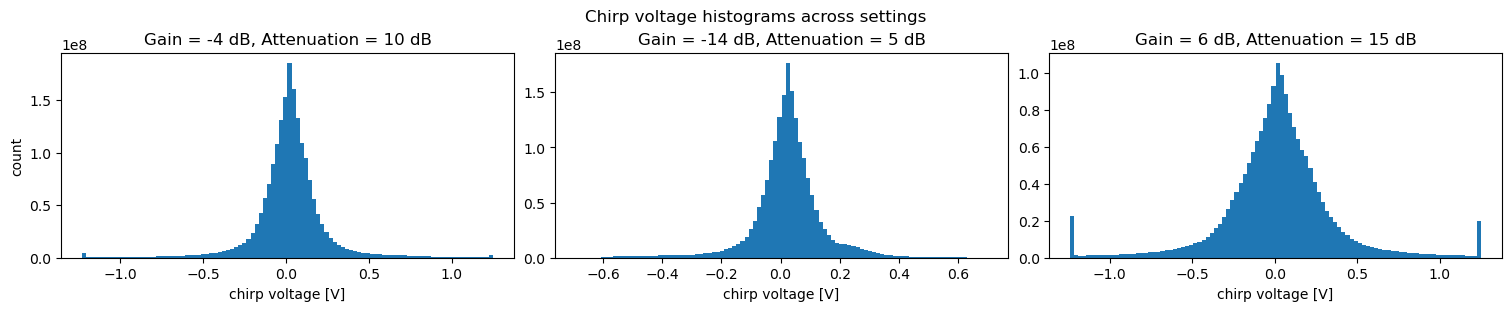

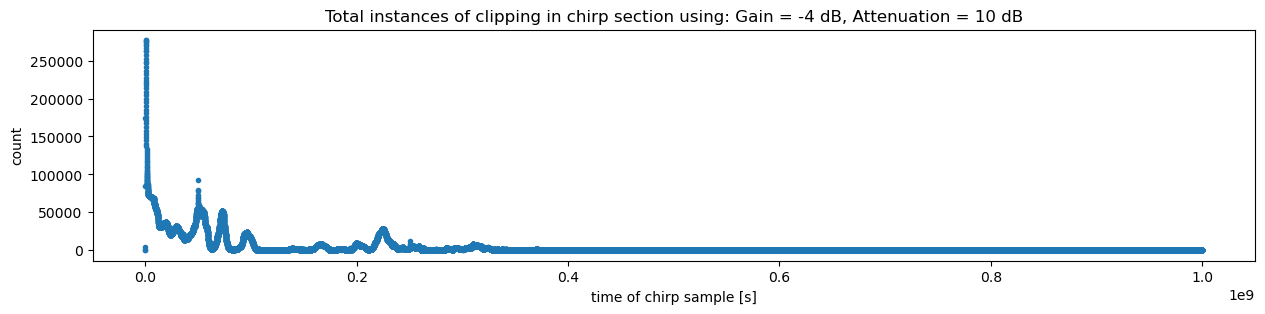

In [22]:
ds_103 = reload_summer("A103")
ds_103 = ds_103.isel(time=range(100,len(ds_103.time))) # trim first few bursts, which were tests

generate_info_plots(ds_103)

### A14 Summer 2022

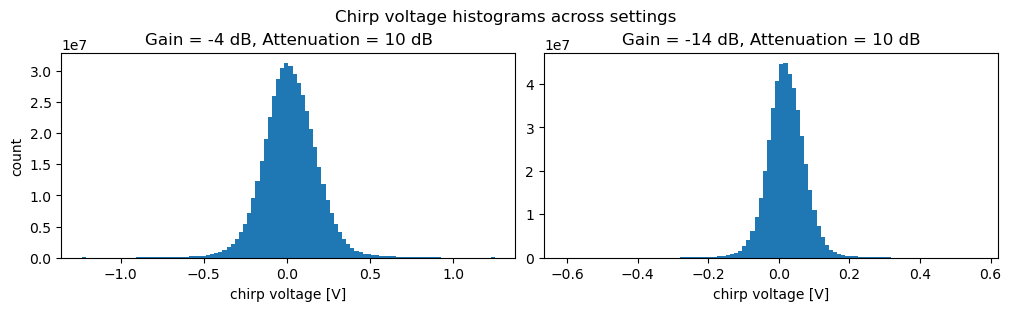

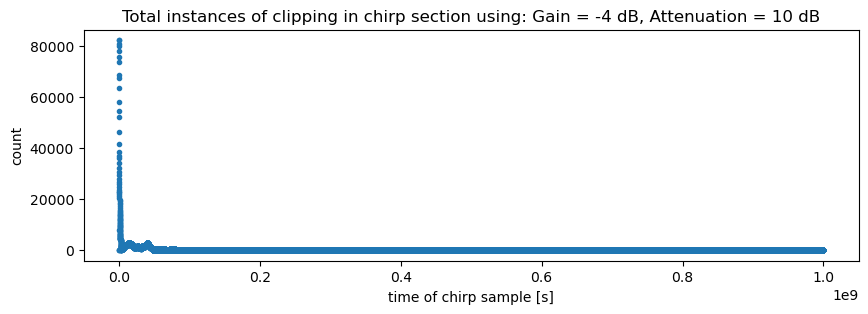

In [23]:
ds_104 = reload("A104")
ds_104 = ds_104.isel(time=range(50,len(ds_104.time))) # trim first few bursts, which were tests
generate_info_plots(ds_104)

### A14 Winter

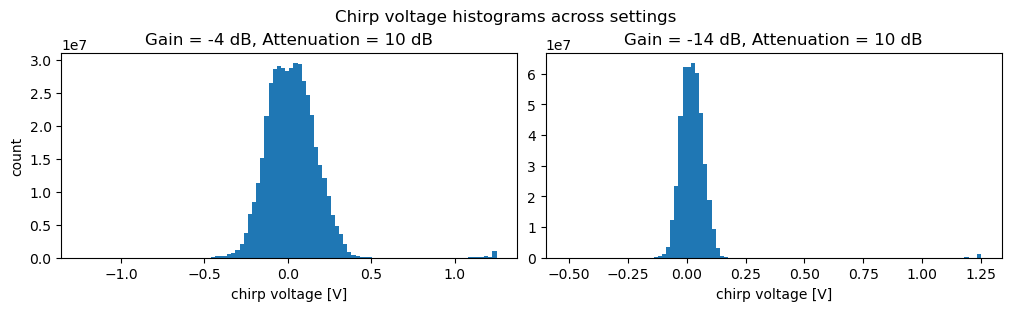

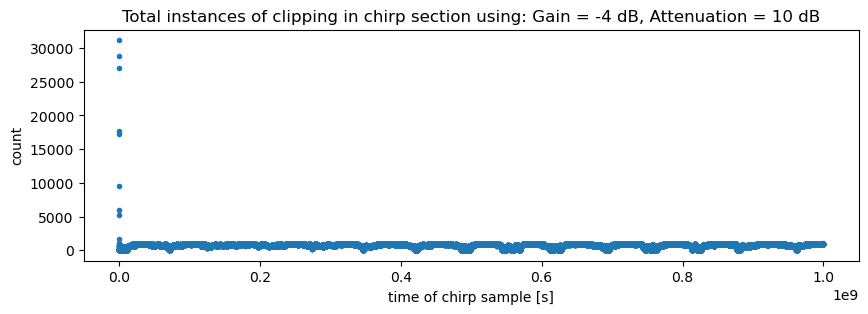

In [24]:
ds_104 = reload_winter("A104")
generate_info_plots(ds_104)

### A14 Summer 2023

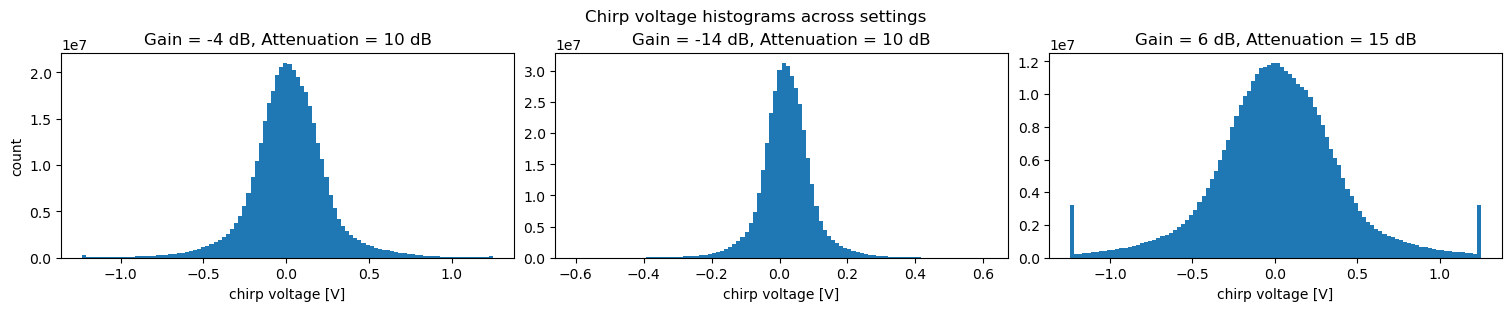

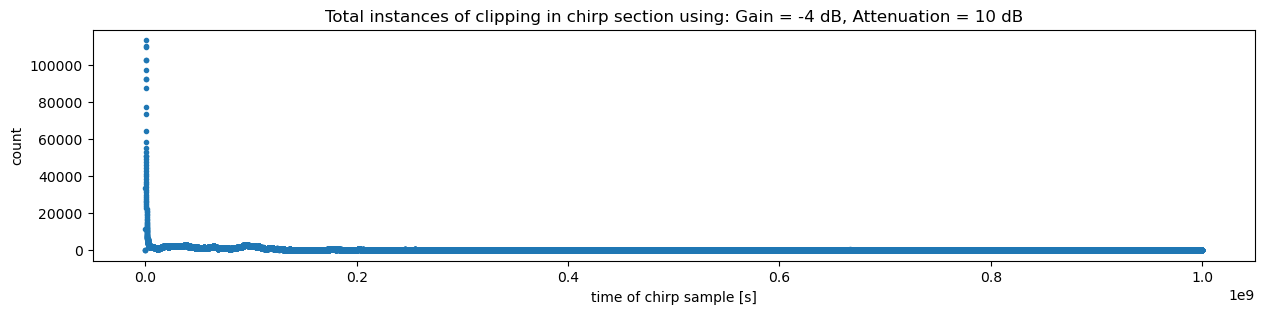

In [25]:
ds_104 = reload_summer("A104")
generate_info_plots(ds_104)

## Cable corrections
In the `part1_profiles` notebook, we correct for the cables by subtracting the location of the mean profile peak. We assert that this location is roughly where the antennas meet the surface, accounting for cables. This is summarized as follows:

The baseband/beat frequency associated with the range estimate is given by:
\begin{equation} \label{eqn:radar_range}
    f_b = \frac{2BR\sqrt{\varepsilon_r}}{Tc},
\end{equation}
where $B$ is the bandwidth of the sweep, $R$ is the target range, $T$ is the pulse duration, $c$ is the speed of light, and $\varepsilon_r$ is the dielectric constant of the medium. Let's consider the round trip path formed by the cables and the ice surface. The total length of the cables at A13 and A14 is about 12.44 m, and the distance between them is 2.5 m. This corresponds to a one-way distance of 6.22 m within the cables and 1.25 m within the ice. Now we use 2.1 and 3.18 as the dielectric constants for the cables and ice. We then use a modified version of the above equation to account for the two different media:
\begin{equation}
    f_b = \frac{2B}{T}\frac{1}{c} \left( d_\mathrm{cable} \sqrt{\varepsilon_{r,\mathrm{cable}}} + d_\mathrm{ice} \sqrt{\varepsilon_{r,\mathrm{ice}}} \right). 
\end{equation}
Plugging in the values for the one-way distances for cables and ice along with their dielectric constants gives a beat frequency of 14.989 Hz, which is quite close to that of the beat frequency obtained from the apparent reflector depth assuming only ice. Plugging this value directly back into single medium equation gives a range of 6.3 m, which is near that of the reflector range observed in the winter at A13 and in the summers at A14.